In [51]:
import sys
import re
import os
import numpy as np
import pandas as pd
import pysam
from Bio.Seq import Seq
from Bio import Restriction
from Bio import SeqIO
from rapidfuzz import fuzz
import rapidfuzz
import regex

In [38]:
nbp = 24
n_mismatch = 10
ref_barcode = 'A' * nbp
test_barcode = 'A' * nbp

for i in range(n_mismatch):
    test_barcode = test_barcode[:i] + 'T' + test_barcode[i+1:]
    result = fuzz.partial_ratio_alignment(test_barcode, ref_barcode)
    print(f"BP MISMATCHES: {i+1} SCORE: {result.score:.1f}")

BP MISMATCHES: 1 SCORE: 97.9
BP MISMATCHES: 2 SCORE: 95.7
BP MISMATCHES: 3 SCORE: 93.3
BP MISMATCHES: 4 SCORE: 90.9
BP MISMATCHES: 5 SCORE: 88.4
BP MISMATCHES: 6 SCORE: 85.7
BP MISMATCHES: 7 SCORE: 82.9
BP MISMATCHES: 8 SCORE: 80.0
BP MISMATCHES: 9 SCORE: 76.9
BP MISMATCHES: 10 SCORE: 73.7


In [61]:
barcode = "AAGAAAGTTGTCGGTGTCTTTGTG"
read_seq = "AAGAAAGTTGTCGGTGTCTTTGTGTGCTGAAGAAGTTGTCGGTGTCTTTGTGTTAACCTTTCTGTTGGTGCTGATATTCCGGTGCTGAAGATAGAGCGACAGGCAAGTAGGTTAACACAAAGACGCCGACAACTTTCTTCAGAAGAAAGTTGTCGGTGTCTTTGTG"

result = fuzz.partial_ratio_alignment(read_seq, barcode)
result

ScoreAlignment(score=100.0, src_start=0, src_end=24, dest_start=0, dest_end=24)

In [89]:
def find_restriction_sites(read_seq, rb):
    """A function to find all restriction sites 
    in a sequence """
    search_results = rb.search(Seq(read_seq))
    sites = list(search_results.values())[0]
    n_sites = len(sites)
    if n_sites == 0:
        sites = [-1]

    site_str = ";".join([str(x) for x in sites])
    return site_str, n_sites


def find_fuzzy(seq, tgt, min_sim):
  """
  Finds all fuzzy matches of the target sequence within the main sequence recursively.

  Args:
      seq: The main sequence to search.
      tgt: The target sequence to find fuzzy matches for.
      min_sim: Minimum similarity threshold (0-100).

  Returns:
      A list of tuples containing the matching character, matched substring, start and end positions, and similarity score.
  """
  matches = []
  best_match = None

  # Find the best alignment using a sliding window and update best_match
  for i in range(len(seq) - len(tgt) + 1):
    sub = seq[i:i + len(tgt)]
    score = fuzz.partial_ratio(tgt, sub)
    if score >= min_sim and (not best_match or score > best_match[4]):
      best_match = (seq[i], sub, i, i + len(tgt) - 1, score)

  # If a match is found, record it and continue recursively
  if best_match:
    matches.append(best_match)
    rem_seq = seq[:best_match[2]] + seq[best_match[3] + 1:]
    matches.extend(find_fuzzy(rem_seq, tgt, min_sim))

  return matches


def find_barcodes(read_seq, barcode, min_sim=92):
    """A function to find barcode sequences in reads """
    barcode_len = len(barcode)

    matches = find_fuzzy(read_seq, barcode, min_sim)
    n_matches = len(matches)
    
    if len(matches) == 0:
        pos = [-1]
        scores = [-1]
    else:
        pos = []
        scores = []
        for i, match in enumerate(matches):
            _, _, start, _, score = match
            # correct alignment positions for striped barcodes
            offset = barcode_len * i            
            start = start + offset
            pos.append(start)
            scores.append(score)

    pos_str = ";".join([str(x) for x in pos])
    score_str = ";".join([str(round(x, 2)) for x in scores])
    return pos_str, score_str, n_matches
    
    


def get_sequence_report(fpath, rb, barcode, barcode_rc):
    """A function to return read-level information 
    from fastq files """
    report_df = []
    
    count = -1
    stop = 500
    for read in pysam.FastxFile(fpath):
        count += 1
        if count == stop:
            break

        # get read information
        read_seq = read.sequence
        read_seq_length = len(read_seq)
        quals = read.get_quality_array()

        # find the restrictin enzyme sites
        enzyme_pos, enzyme_matches = find_restriction_sites(read_seq, rb)

        # find forward barcodes
        fw_pos_str, fw_score_str, fw_n_matches = find_barcodes(read_seq, barcode)

        # find reverse complement barcodes
        rv_pos_str, rv_score_str, rv_n_matches = find_barcodes(read_seq, barcode_rc)

        # total BC
        total_bc_matches = fw_n_matches + rv_n_matches

        row = {
            'read_name' : read.name,
            'read_seq_length' : read_seq_length,
            'enzyme_matches' : enzyme_matches,
            'enzyme_pos' : enzyme_pos,
            'total_bc_matches' : total_bc_matches,
            'forward_bc_pos' : fw_pos_str,
            'forward_bc_score' : fw_score_str,
            'forward_bc_macthes' : fw_n_matches,
            'reverse_bc_pos' : rv_pos_str,
            'reverse_bc_score' : rv_score_str,
            'reverse_bc_macthes' : rv_n_matches,
            'mean_base_quality' : int(np.mean(quals)),
            'median_base_quality' : int(np.median(quals)),
            'min_base_quality' : np.min(quals),
            'max_base_quality' : np.max(quals),
        }
        report_df.append(row)
    return pd.DataFrame(report_df)
    

fastq_path = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/fastq/b01.raw.fastq"
barcode_path = "../config/barcodes.txt"
enzyme = 'NlaIII'

# set up restriction enzyme
rb = Restriction.RestrictionBatch([enzyme])

# set up get barcodes
barcode_id = os.path.basename(fastq_path).split(".")[0]
code_df = pd.read_csv(barcode_path)
barcode = code_df[code_df['cell_id'] == barcode_id]['barcode'].values[0]
barcode_rc = str(Seq(barcode).reverse_complement())

df = get_sequence_report(fastq_path, rb, barcode, barcode_rc)
df.head()

,read_name,read_seq_length,enzyme_matches,enzyme_pos,total_bc_matches,forward_bc_pos,forward_bc_score,forward_bc_macthes,reverse_bc_pos,reverse_bc_score,reverse_bc_macthes,mean_base_quality,median_base_quality,min_base_quality,max_base_quality
0,94492ea9-f8de-4007-8cc9-7a31801f68ac,270,0,-1,5,-1,-1,0,6;65;184;243;173,100.0;100.0;100.0;100.0;95.83,5,36,39,4,50
1,8401aa43-69d4-40a0-abcc-8a2e110b2430,213,0,-1,4,-1,-1,0,9;68;127;186,100.0;100.0;100.0;100.0,4,37,41,6,50
2,e3c73ad8-ae4c-4965-b0ff-1f575306ff14,468,0,-1,7,-1,-1,0,20;79;160;222;441;404;351,100.0;100.0;100.0;100.0;100.0;97.87;95.83,7,41,43,6,50
3,f536f761-c128-4cde-a247-8b3a924b3399,118,0,-1,2,4,97.87,1,91,95.83,1,31,36,7,50
4,5faf5728-3f2e-4d37-8f62-574673a1662e,48,0,-1,1,-1,-1,0,20,100.0,1,43,42,28,50


In [ ]:
n_sample = 75
n_rows = 2500
root_dir = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/fastq/p2/"

res = []

def read_fastq(fpath, n_rows):
    """a function to parse a fastq file """
    count = -1
    res = []
    for read in pysam.FastxFile(fpath):
        count += 1
        if count == n_rows:
            break

        NlaIII = read.sequence.count('CATG')
        quals = read.get_quality_array()
        row = {
            'read_name' : read.name,
            'seq_length' : len(read.sequence),
            'n_NlaIII' : NlaIII,
            'mean_base_quality' : np.mean(quals),
            'median_base_quality' : np.median(quals),
            'min_base_quality' : np.min(quals),
            'max_base_quality' : np.max(quals),
            'sequence' : read.sequence,
        }

        res.append(row)
    return pd.DataFrame(res)
    
res = []
for run in os.listdir(root_dir):

    subdir_path = f"{root_dir}{run}/merged_fastq/"
    sample_files = np.random.choice(os.listdir(subdir_path), n_sample)
    sample_files = [x for x in sample_files if not x == 'unclassified.fastq']

    for sample in sample_files:
        sample_path = f"{subdir_path}{sample}"

        bc_number = sample.replace("barcode", "").replace(".fastq", "")
        bc_id = f"BC{bc_number}"

        df = read_fastq(sample_path, n_rows)
        df['run'] = run
        df['barcode'] = bc_id
        res.append(df)

res = pd.concat(res)
print(f"{res.shape=}")
print(f"{res['read_name'].nunique()=}")
res.head()

In [3]:
# load ont_barcodes
fpath = "../resources/ONT_barcode_96_sequences.csv"
df = pd.read_csv(fpath)
codes = dict(zip(df.Barcode.values, df.Sequence.values))
df.head()

,Barcode,Sequence,IDs
0,BC01,AAGAAAGTTGTCGGTGTCTTTGTG,BC01 / RB01
1,BC02,TCGATTCCGTTTGTAGTCGTCTGT,BC02 / RB02
2,BC03,GAGTCTTGTGTCCCAGTTACCAGG,BC03 / RB03
3,BC04,TTCGGATTCTATCGTGTTTCCCTA,BC04 / RB04
4,BC05,CTTGTCCAGGGTTTGTGTAACCTT,BC05 / RB05


In [ ]:
break

In [4]:
# for _, record in res.sample(40).iterrows():
#     barcode = record['barcode']
#     read_name = record['read_name']
#     ont_seq = codes[barcode]
#     read_seq = record['sequence']
#     seq_len = record["seq_length"]
#     n_NlaIII = record["n_NlaIII"]

#     rev_comp = str(Seq(barcode).reverse_complement())

#     has_code = ont_seq in read_seq
#     has_code_rev = rev_comp in read_seq
#     print(f"{barcode=} {n_NlaIII=} {seq_len=} {has_code=}")

In [5]:
df = []

for _, record in res.iterrows():
    barcode = record['barcode']
    read_name = record['read_name']
    ont_seq = codes[barcode]
    read_seq = record['sequence']
    seq_len = record["seq_length"]
    n_NlaIII = record["n_NlaIII"]

    hits = read_seq.count(ont_seq)
    hits_rc = read_seq.count(str(Seq(ont_seq).reverse_complement()))

    row = {
        'run' : record['run'],
        'read_name' : read_name,
        'barcode' : barcode,
        'seq_len' : seq_len,
        'n_NlaIII' : n_NlaIII,
        'n_barcodes' : hits,
        'n_barcodes_rc' : hits_rc,
        'mean_base_quality' : record['mean_base_quality'],
    }

    df.append(row)

df  = pd.DataFrame(df)
df.head()


,run,read_name,barcode,seq_len,n_NlaIII,n_barcodes,n_barcodes_rc,mean_base_quality
0,scPC96o_3,e4f147b7-9db9-4554-bb34-5115a6505260,BC41,862,2,1,1,15.912993
1,scPC96o_3,6a3209e7-b4a7-4af2-a578-14a3cf36399a,BC41,1137,3,1,1,16.314864
2,scPC96o_3,d27e52bb-49c9-42b0-a4df-6280f45304d2,BC41,569,0,0,0,30.622144
3,scPC96o_3,eca5a048-afa4-4c5e-a2d9-ab8cf93e66fb,BC41,282,0,1,0,31.567376
4,scPC96o_3,cc17745a-4ff2-4d50-90a6-5f6b87a96d18,BC41,1017,0,0,1,16.398230


# count NlaIII sites

In [6]:
df['ord'] = np.where(df['n_NlaIII'] == 0, 'none', 'higher')
df['ord'] = np.where(df['n_NlaIII'] == 1, 'pair', df['ord'] )
df['ord'].value_counts(normalize=True)

ord
higher    0.473126
none      0.424033
pair      0.102841
Name: proportion, dtype: float64

# count barcodes

In [7]:
df['cat'] = np.where(df['n_barcodes'] == 1, 'one', 'none')
df['cat'] = np.where(df['n_barcodes'] > 1, 'mulitple', df['cat'])

print(df.shape)
print(df['barcode'].nunique())
df['cat'].value_counts(normalize=True)

(554981, 10)
84


cat
one         0.518663
none        0.280118
mulitple    0.201220
Name: proportion, dtype: float64

In [8]:
df['cat_rc'] = np.where(df['n_barcodes_rc'] == 1, 'one', 'none')
df['cat_rc'] = np.where(df['n_barcodes_rc'] > 1, 'mulitple', df['cat_rc'])

print(df.shape)
print(df['barcode'].nunique())
df['cat_rc'].value_counts(normalize=True)

(554981, 11)
84


cat_rc
none        0.420795
one         0.385175
mulitple    0.194030
Name: proportion, dtype: float64

ord         higher      none      pair
cat                                   
mulitple  0.031781  0.140771  0.028668
none      0.130732  0.120116  0.029269
one       0.310612  0.163146  0.044904


<AxesSubplot: xlabel='ord', ylabel='cat'>

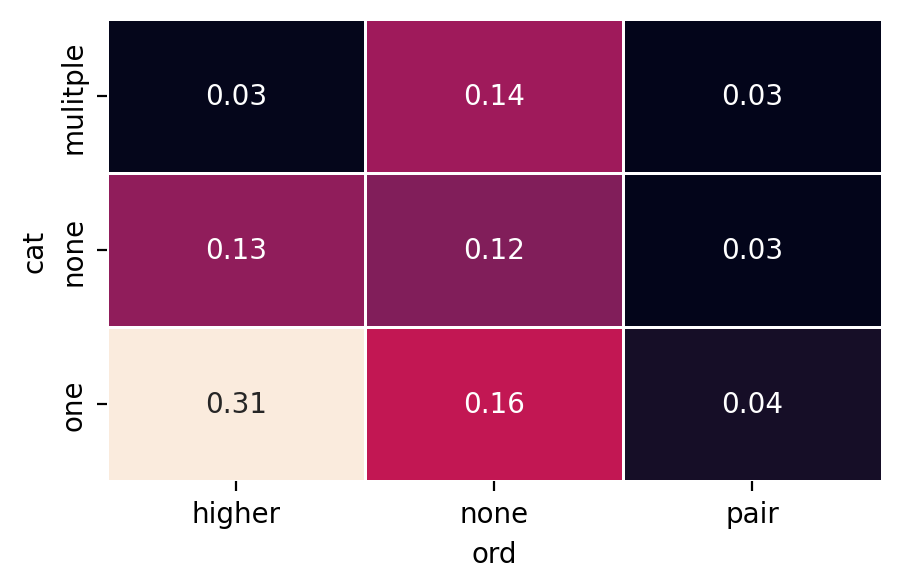

In [9]:
plt.rcParams['figure.figsize'] = 5, 3
plt.rcParams['figure.dpi'] = 200

M = pd.crosstab(df['cat'], df['ord'], normalize=True)
print(M)
sns.heatmap(M, annot=True,  fmt=".2f", lw=1, cbar=False)

ord         higher      none      pair
cat_rc                                
mulitple  0.035825  0.131844  0.026361
none      0.158458  0.213297  0.049040
one       0.278844  0.078891  0.027441


<AxesSubplot: xlabel='ord', ylabel='cat_rc'>

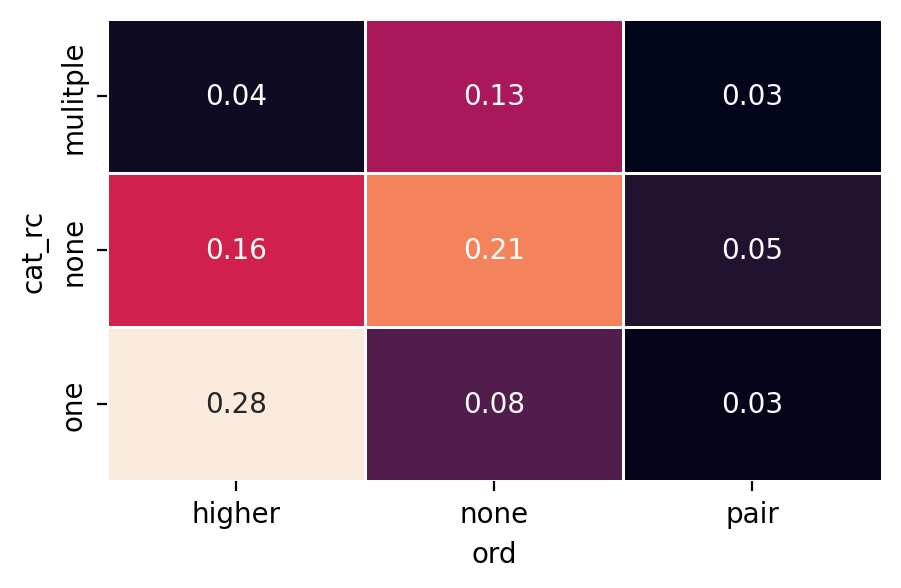

In [10]:
plt.rcParams['figure.figsize'] = 5, 3
plt.rcParams['figure.dpi'] = 200

M = pd.crosstab(df['cat_rc'], df['ord'], normalize=True)
print(M)
sns.heatmap(M, annot=True,  fmt=".2f", lw=1, cbar=False)

cat_rc    mulitple      none       one
cat                                   
mulitple  0.077177  0.080273  0.043769
none      0.063251  0.106746  0.110121
one       0.053602  0.233776  0.231285


<AxesSubplot: xlabel='cat_rc', ylabel='cat'>

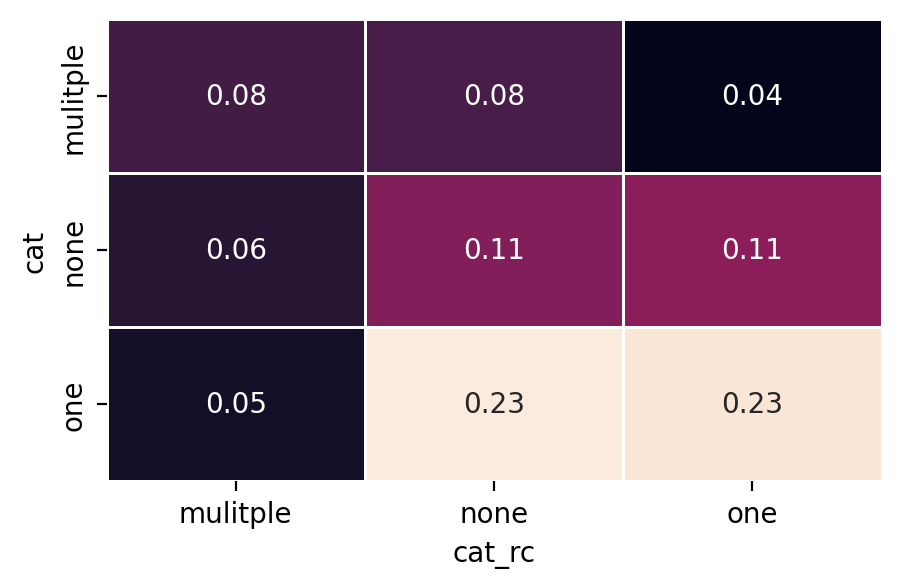

In [11]:
plt.rcParams['figure.figsize'] = 5, 3
plt.rcParams['figure.dpi'] = 200

M = pd.crosstab(df['cat'], df['cat_rc'], normalize=True)
print(M)
sns.heatmap(M, annot=True,  fmt=".2f", lw=1, cbar=False)

# number of reads with exactly one barcode (RC + forward)

In [12]:
test = df[df['n_barcodes'].isin([0, 1])]
test = test[test['n_barcodes_rc'].isin([0, 1])]

test = test[(test['n_barcodes'] != 0) & (test['n_barcodes_rc'] != 0)]

print(f"{test.shape=}")
print(test['ord'].value_counts(normalize=True))

test.head()

test.shape=(128359, 11)
ord
higher    0.855842
none      0.093332
pair      0.050826
Name: proportion, dtype: float64


,run,read_name,barcode,seq_len,n_NlaIII,n_barcodes,n_barcodes_rc,mean_base_quality,ord,cat,cat_rc
0,scPC96o_3,e4f147b7-9db9-4554-bb34-5115a6505260,BC41,862,2,1,1,15.912993,higher,one,one
1,scPC96o_3,6a3209e7-b4a7-4af2-a578-14a3cf36399a,BC41,1137,3,1,1,16.314864,higher,one,one
17,scPC96o_3,ff129ab2-dc56-4d8e-994e-10502197f29c,BC41,1228,6,1,1,16.552932,higher,one,one
25,scPC96o_3,a531eb96-2a43-4a8d-88f9-3a74454e08f6,BC41,1861,5,1,1,17.165502,higher,one,one
34,scPC96o_3,ebc2faf8-b434-4ee6-ac14-84cd85c42310,BC41,1212,11,1,1,16.862211,higher,one,one


Mon Mar  4 10:54:06 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Mar  4 10:54:07 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


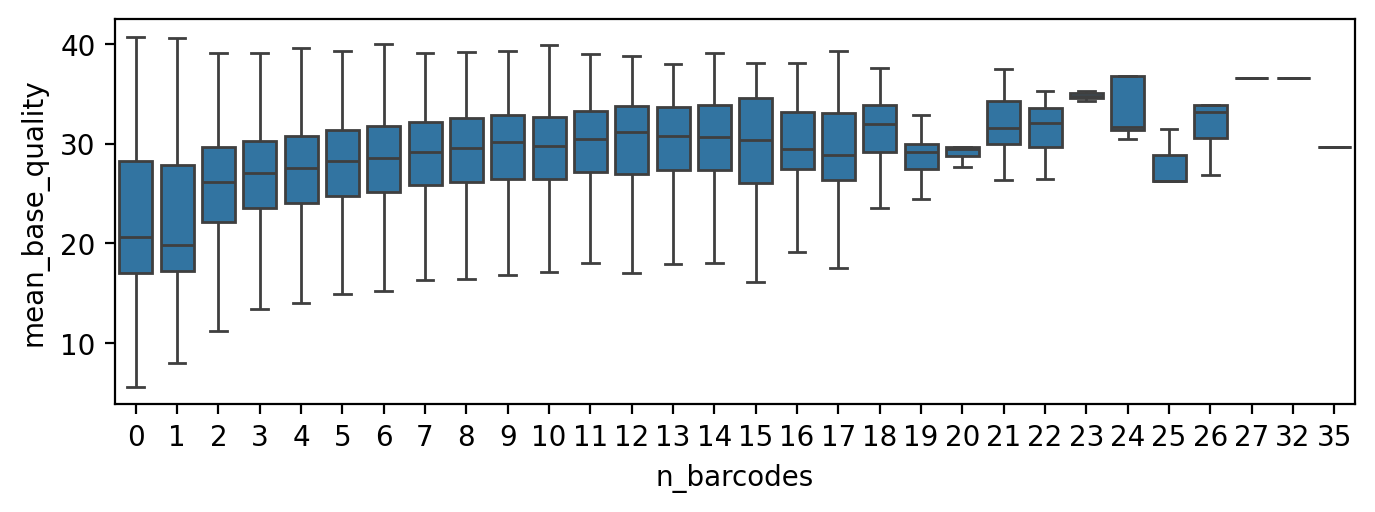

In [13]:
plt.rcParams['figure.figsize'] = 8, 2.5
plt.rcParams['figure.dpi'] = 200

sns.boxplot(data=df, 
                x='n_barcodes',
                y='mean_base_quality',
                showfliers=False)

plt.show()

Mon Mar  4 10:54:07 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Mar  4 10:54:08 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


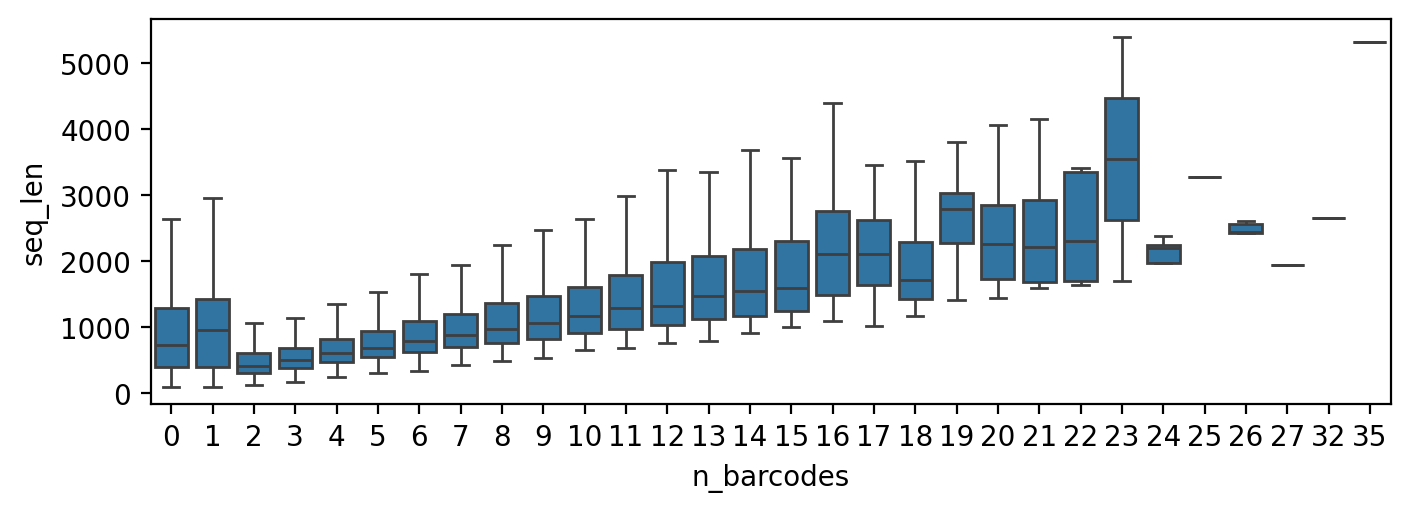

In [14]:
plt.rcParams['figure.figsize'] = 8, 2.5
plt.rcParams['figure.dpi'] = 200

sns.boxplot(data=df, 
                x='n_barcodes',
                y='seq_len',
                showfliers=False)
plt.show()

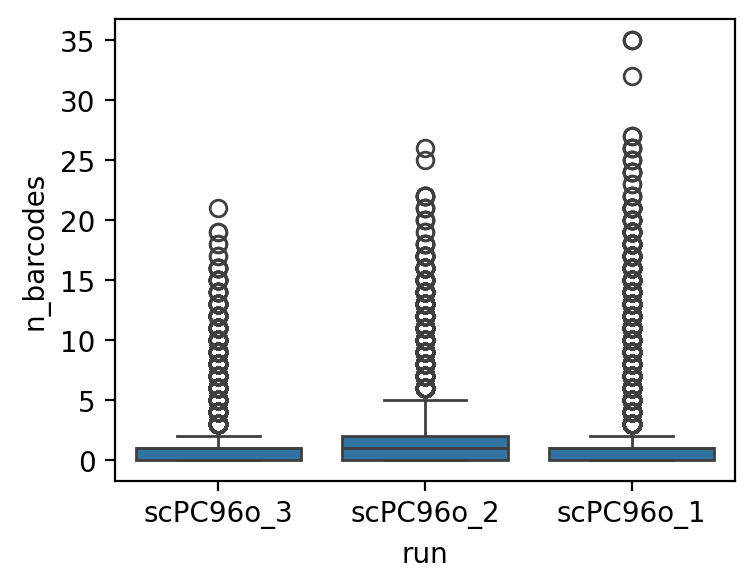

In [15]:
plt.rcParams['figure.figsize'] = 4, 3
plt.rcParams['figure.dpi'] = 200

sns.boxplot(data=df, 
                x='run',
                y='n_barcodes')
plt.show()

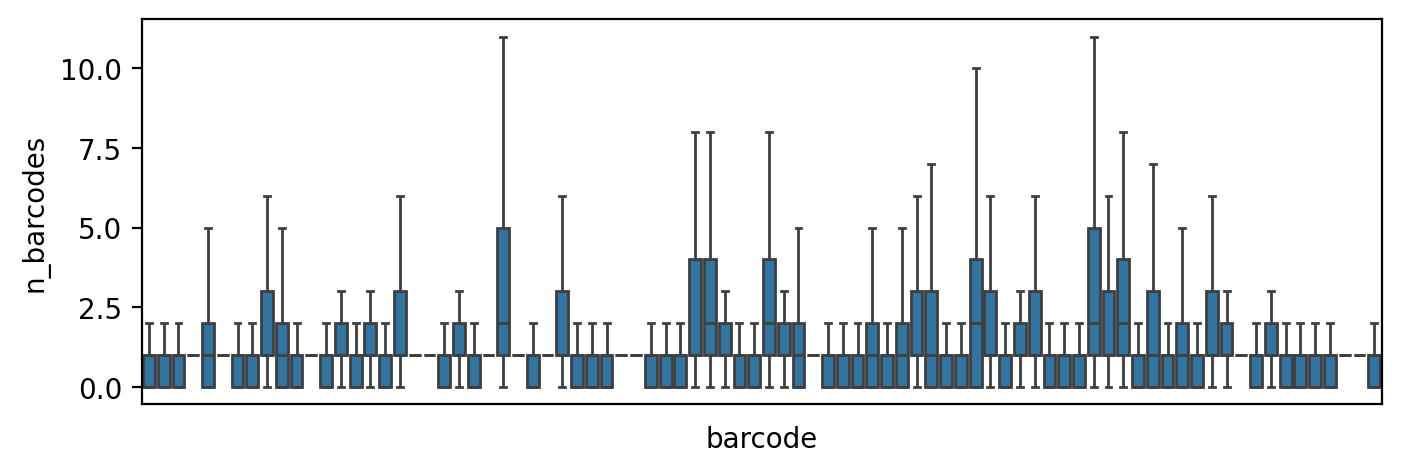

In [16]:
plt.rcParams['figure.figsize'] = 8, 2.5
plt.rcParams['figure.dpi'] = 200

sns.boxplot(data=df,
            x='barcode',
            y='n_barcodes',
            showfliers=False)

plt.xticks([])
plt.show()

# multiple barcodes

In [17]:
# let's look at a few extreme cases
barcodes = df[df['n_barcodes'] > 15]['read_name'].unique()
pdf = res[res['read_name'].isin(barcodes)]

for _, record in pdf.head(10).iterrows():
    print("===== ", record['run'], record['barcode'], " =====")
    ont_seq = codes[record['barcode']]
    ont_seq_rc = str(Seq(ont_seq).reverse_complement())
    print('READ NAME: ', record['read_name'])
    print('NUMBER NlaIII SITES: ', record['n_NlaIII'])
    print('ONT BARCODE: ', ont_seq)
    print('ONT BARCODE (RC): ', ont_seq_rc)

    red_ont = f"\033[91m{ont_seq}\033[0m"
    blue_ont = f"\033[94m{ont_seq_rc}\033[0m"
    cutter = f"\033[92mCATG\033[0m"
    highlighted_text = re.sub(ont_seq, red_ont, record['sequence'])
    highlighted_text = re.sub(ont_seq_rc, blue_ont, highlighted_text)
    highlighted_text = re.sub('CATG', cutter, highlighted_text)
    print('READ SEQUENCE: ', highlighted_text)
    print()

=====  scPC96o_3 BC68  =====
READ NAME:  4894c20a-9e2e-4dc0-8903-1b07f3409177
NUMBER NlaIII SITES:  5
ONT BARCODE:  GAATCTAAGCAAACACGAAGGTGG
ONT BARCODE (RC):  CCACCTTCGTGTTTGCTTAGATTC
READ SEQUENCE:  TTATGTCGTTACTTCGTTCAGTTACGTATTGCTGCTGGAATCTAAGCAAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGCTTGCTGGAATCTAAGCAAACACGAAGATAGAGCGACAGGCAAGTAGGTTAACCACCTTCGTGTTTGCTTGATTCCAGCACCAGCATGCGGTGCTGGAATCTAAGCAAACACGAAGGTGGTTAACCTACTTCCTGTCGCTCTATCTTCGGTGCTGGAATCTAAGCGAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGCTGGTGCTGGAATCTAAGCAAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGGAATCTAAGCAAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGCGGTGGTGCTGGAATCTAAGCAAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGGATCTTAAGCAAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGGATCTAAGCAAACACGAAGGTGGTTAACCCTTCTGTTGGTGCTGATATTGTGGTGCTGGAATCTAAGCAAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGGAATCTAAGCAAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGCGGTGCTGGAATCTAAGCAAACACGAAGGTGGTTAACCTTTCTGTTGGTGCTGATATTGTGGTGCTGGAATCTAAGCAAACACGAAGGT

# Extactly one forward barcode

In [18]:
# let's look at a few extreme cases
barcodes = df[(df['n_barcodes'] == 1) ]['read_name'].unique()
pdf = res[res['read_name'].isin(barcodes)]


for _, record in pdf.head(10).iterrows():
    print("===== ", record['run'], record['barcode'], " =====")
    ont_seq = codes[record['barcode']]
    ont_seq_rc = str(Seq(ont_seq).reverse_complement())
    print('READ NAME: ', record['read_name'])
    print('NUMBER NlaIII SITES: ', record['n_NlaIII'])
    print('ONT BARCODE: ', ont_seq)
    print('ONT BARCODE (RC): ', ont_seq_rc)

    red_ont = f"\033[91m{ont_seq}\033[0m"
    blue_ont = f"\033[94m{ont_seq_rc}\033[0m"
    cutter = f"\033[92mCATG\033[0m"
    highlighted_text = re.sub(ont_seq, red_ont, record['sequence'])
    highlighted_text = re.sub(ont_seq_rc, blue_ont, highlighted_text)
    highlighted_text = re.sub('CATG', cutter, highlighted_text)
    print('READ SEQUENCE: ', highlighted_text)
    print()


=====  scPC96o_3 BC41  =====
READ NAME:  e4f147b7-9db9-4554-bb34-5115a6505260
NUMBER NlaIII SITES:  2
ONT BARCODE:  GGAGTTCGTCCAGAGAAGTACACG
ONT BARCODE (RC):  CGTGTACTTCTCTGGACGAACTCC
READ SEQUENCE:  ATGTGCCTGTACTTCGGTTCAGTTACGTATTGCTGGTGCTGGGAGTTCGTCCAGAGAAGTACACGTTAACCTTTCTGTTGGTGCTGATATTGTGGTTCCTGGTGTGTATGGCTGGATTTTGAGAGACCACAGGTTTATAGGAGTCTTCAGGATTGAAAAGGAAGTATAATCTCAGTACAAACTAGAGGCCAAAAGAGAAACAACACAGGTATAAGAAAATATATTTGGGGTCAATACTATTCACTACTGCAGTATGATAAACACTTGTTTAGTTTTTGTGGATGCAGCTATGAACCAAACGAATTTTAGCAGGGCATGGTGGATGGGACATGTCTTGAACCCAGGACCAGTAAGAAACGGTGCTCTAAATTCTAATACCAACACATTAAAAGTTAATAGCCGTAAATTTCCCGACCAGATACTTAATGCCATACAAAAATCTTTACCAATTTCACCAAGAGCAAAATTCAAATTTTAATGTACACAGTATAGTTGGCTAACAGCAGAGGGGGAACAAAACAAAATACTGGAGTTGAGTAAGGTTTGTTTTAATACTCACTAAAATTTATTAACCACTCCAAACATTCTATAATAAAGATAAAATATTTACAACTATTTATGGGACAACTTAGAGGAAGTGAGGAATAACGAGCTTTTAAAAGTCCTAACCTCCCACAAGGAGGGGACATACAGTGGGTTTGGAGGTACTGTTTTGTTTTGTATTATTTTTAATGGAAGGAATTTCTGTTTATCAGACATTCAAGCACAAAGGTTAAACACCCAAGCAGACGCCGAAGAT

In [19]:
# let's look at a few extreme cases
barcodes = df[(df['n_barcodes_rc'] == 1) ]['read_name'].unique()
pdf = res[res['read_name'].isin(barcodes)]


for _, record in pdf.head(10).iterrows():
    print("===== ", record['run'], record['barcode'], " =====")
    ont_seq = codes[record['barcode']]
    ont_seq_rc = str(Seq(ont_seq).reverse_complement())
    print('READ NAME: ', record['read_name'])
    print('NUMBER NlaIII SITES: ', record['n_NlaIII'])
    print('ONT BARCODE: ', ont_seq)
    print('ONT BARCODE (RC): ', ont_seq_rc)

    red_ont = f"\033[91m{ont_seq}\033[0m"
    blue_ont = f"\033[94m{ont_seq_rc}\033[0m"
    cutter = f"\033[92mCATG\033[0m"
    highlighted_text = re.sub(ont_seq, red_ont, record['sequence'])
    highlighted_text = re.sub(ont_seq_rc, blue_ont, highlighted_text)
    highlighted_text = re.sub('CATG', cutter, highlighted_text)
    print('READ SEQUENCE: ', highlighted_text)
    print()

=====  scPC96o_3 BC41  =====
READ NAME:  e4f147b7-9db9-4554-bb34-5115a6505260
NUMBER NlaIII SITES:  2
ONT BARCODE:  GGAGTTCGTCCAGAGAAGTACACG
ONT BARCODE (RC):  CGTGTACTTCTCTGGACGAACTCC
READ SEQUENCE:  ATGTGCCTGTACTTCGGTTCAGTTACGTATTGCTGGTGCTGGGAGTTCGTCCAGAGAAGTACACGTTAACCTTTCTGTTGGTGCTGATATTGTGGTTCCTGGTGTGTATGGCTGGATTTTGAGAGACCACAGGTTTATAGGAGTCTTCAGGATTGAAAAGGAAGTATAATCTCAGTACAAACTAGAGGCCAAAAGAGAAACAACACAGGTATAAGAAAATATATTTGGGGTCAATACTATTCACTACTGCAGTATGATAAACACTTGTTTAGTTTTTGTGGATGCAGCTATGAACCAAACGAATTTTAGCAGGGCATGGTGGATGGGACATGTCTTGAACCCAGGACCAGTAAGAAACGGTGCTCTAAATTCTAATACCAACACATTAAAAGTTAATAGCCGTAAATTTCCCGACCAGATACTTAATGCCATACAAAAATCTTTACCAATTTCACCAAGAGCAAAATTCAAATTTTAATGTACACAGTATAGTTGGCTAACAGCAGAGGGGGAACAAAACAAAATACTGGAGTTGAGTAAGGTTTGTTTTAATACTCACTAAAATTTATTAACCACTCCAAACATTCTATAATAAAGATAAAATATTTACAACTATTTATGGGACAACTTAGAGGAAGTGAGGAATAACGAGCTTTTAAAAGTCCTAACCTCCCACAAGGAGGGGACATACAGTGGGTTTGGAGGTACTGTTTTGTTTTGTATTATTTTTAATGGAAGGAATTTCTGTTTATCAGACATTCAAGCACAAAGGTTAAACACCCAAGCAGACGCCGAAGAT

# No forward barcodes, reverse only

In [20]:
# let's look at a few extreme cases
barcodes = df[(df['n_barcodes'] == 0) & (df['n_barcodes_rc'] == 1) ]['read_name'].unique()
pdf = res[res['read_name'].isin(barcodes)]


for _, record in pdf.head(10).iterrows():
    print("===== ", record['run'], record['barcode'], " =====")
    ont_seq = codes[record['barcode']]
    ont_seq_rc = str(Seq(ont_seq).reverse_complement())
    print('READ NAME: ', record['read_name'])
    print('NUMBER NlaIII SITES: ', record['n_NlaIII'])
    print('ONT BARCODE: ', ont_seq)
    print('ONT BARCODE (RC): ', ont_seq_rc)

    red_ont = f"\033[91m{ont_seq}\033[0m"
    blue_ont = f"\033[94m{ont_seq_rc}\033[0m"
    cutter = f"\033[92mCATG\033[0m"
    highlighted_text = re.sub(ont_seq, red_ont, record['sequence'])
    highlighted_text = re.sub(ont_seq_rc, blue_ont, highlighted_text)
    highlighted_text = re.sub('CATG', cutter, highlighted_text)
    print('READ SEQUENCE: ', highlighted_text)
    print()


=====  scPC96o_3 BC41  =====
READ NAME:  cc17745a-4ff2-4d50-90a6-5f6b87a96d18
NUMBER NlaIII SITES:  0
ONT BARCODE:  GGAGTTCGTCCAGAGAAGTACACG
ONT BARCODE (RC):  CGTGTACTTCTCTGGACGAACTCC
READ SEQUENCE:  GCTCTGTTTTTGCCTGTTACTTGGTTCAGTTACGTATTGCTGTCTCATCTTCCACAGCACTACAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCGCAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCGCAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCGCAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGTATCATCTTCACAGCACCGCAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCGCAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCGCAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCACAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTCCACAGCACCACAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCACAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCACAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCACAATATCAGCACCAACAGAAAGGTTAACGTAGATCAGGGTCTCATCTTCCACAGCACCGCAATATCAGCACCAACAGAAAGGTTAACGTAGA

In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# look for all barcodes in a few sequences
for _, record in res.sample(100).iterrows():
    read_seq = record['sequence']
    barcode = record['barcode']
    for bc, ont_seq in codes.items():
        if ont_seq in read_seq:
            print(f"cell barcode: {barcode} found: {bc}")